# <font color = red >Minimum Satisfiability

### Import required libraries

In [35]:
import itertools
import functools
from typing import Iterable

import pennylane as qml
from pennylane.wires import Wires
from pennylane import numpy as np
from pennylane import qaoa

### Constructing Hamiltonian

$H = X_0 + X_1$
    

In [ ]:
coeffs = [1,1]
terms  = [qml.PauliX(0),qml.PauliX(1)]
print(qml.Hamiltonian(coeffs,terms))

$H = X_0 Z_1 $

In [ ]:
coeffs = [1]
terms  = [qml.PauliX(0)@qml.PauliZ(1)]
print(qml.Hamiltonian(coeffs,terms))

$ H = W_0 ;$ $W = \ket{1}\bra{1} = 0.5(I - Z )$

In [ ]:
coeffs = [0.5, -0.5]
terms = [qml.Identity(0),qml.PauliZ(0)]
print(qml.Hamiltonian(coeffs,terms))

$H = 0.5 * X_0Z_1 + 0.3 * Z_0X_1$

$H = W_0 \bar{W}_1$

In [ ]:
coeffs_0 = [0.5,-0.5]
coeffs_1 = [0.5, 0.5]
n_coeffs = [coeffs_0,coeffs_1]

terms_0  = [qml.Identity(0),qml.PauliZ(0)]
terms_1  = [qml.Identity(1),qml.PauliZ(1)]
n_terms  = [terms_0,terms_1]

coeffs   = [functools.reduce(lambda x, y: x * y, list(m), 1) for m in itertools.product(*n_coeffs)]
terms    = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]

print("n_coeffs = ", n_coeffs)
print("co-efficients = ", coeffs)
print("------------------------")
print("n_terms = ", *n_terms)
print("terms = ", *terms) 
print("------------------------")
H = qml.Hamiltonian(coeffs,terms)
print('H = ', H)

Try $ H = W_0 \bar{W}_1 \bar{W}_2 $

###  Notation for clauses

<ol>
<li>Give numbers to each literal starting from 0. </li>
<li>Each clause is represented as tuple of two lists.</li>
<li>First list contains literals that are not negated in the clause.</li>
<li>Second list contains literals that are negated in the clause.</li>
<li>If j th clause is (a v b v ~c) it is represented as c_j = ([0,1],[2]).</li>
</ol>

In [3]:
# Using the notation described above construct the following clauses 

## Clause 1: a v b v c
c_1 = ([0,1,2],[])
## Clause 2: ~a v ~b v ~c
c_2 = ([],[0,1,2])
## Clause 3: ~a v b v c
c_3 = ([1,2],[0])
## Clause 4: a v ~b v ~c
c_4 = ([0],[1,2])
## Clause 5: a v ~b v c
c_5 = ([0,2],[1])

# Now define a list which is a collection of all clauses

Clauses = [c_1,c_2,c_3,c_4,c_5]


### Mixer Hamiltonian


$$H_M =  \sum_i X_i $$
where, $i \in Literals$

In [1]:
def mixer_min_sat(clauses,no_of_literals):
    
    # Create two empty lists named coeffs and terms to store coefficients and terms for the mixer hamiltonian
    coeffs = []
    terms = []
    # For all literals add a PauliX gate to terms list and coefficient of each PauliX is equal to 1
    for l in range(no_of_literals):
        coeffs += [1]
        terms  += [qml.PauliX(l)]
    # Return hamiltonian with given Coefficients and terms
    return qml.Hamiltonian(coeffs,terms)

In [6]:
# Check if the hamiltonain of mixer is correct or not for constructed clauses
print(mixer_min_sat(Clauses,3))


  (1) [X0]
+ (1) [X1]
+ (1) [X2]


### Cost Hamiltonian

<ol>
    <li> Cost hamiltonian contains sum of cost of each clause. </li>
    <li> Each clause cost is either 1 or 0 depending on wether the clause is satisfied or not respectively.</li>
    <li> As mentioned above each clause is represented by a tuple with two lists. First list contains the terms which are not negated and second list contains the terms which are negated.</li>
    <li> Each clause contributes a product which contains product of $\bar{W} = \ket{0}\bra{0}$ for terms in first list and $W = \ket{1}\bra{1}$ for terms in second list. </li>
    <li> For clause  c_j = (p,q) where p represents list of literals that are not negated and q represents the list of literals that are negated the cost is given by $$Cost_j = \prod_p \bar{W}_p \prod_q W_q$$ </li>
    <li> Total cost hamiltonian is given by $$H_c = - \sum_j Cost_j$$ </li>
    
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
        

In [44]:
def cost_min_sat(clauses,no_of_literals):
    # Create two empty lists called coeffs and terms to store co-efficients and terms for the cost hamiltonian
    coeffs = []
    terms = []
    # Iterate over each clause in the list clauses
    for clause in clauses:
        # Create two empty lists called n_coeffs and n_terms to store co-efficients and terms of each clause's cost function
        n_coeffs = []
        n_terms = []
        # Add \bar{W} terms to n_coeffs and n_terms for literals in first list 
        for j in clause[0]:
            n_coeffs += [[0.5,0.5]]
            n_terms  += [[qml.Identity(j),qml.PauliZ(j)]]
        # Add W terms to n_coeffs and n_terms for literals in second list 
        for j in clause[1]:
            n_coeffs += [[0.5,-0.5]]
            n_terms  += [[qml.Identity(j),qml.PauliZ(j)]]
        # Compute the product of all \bar{W} and W terms in lists n_coeffs and n_terms
        # Store them in two new lists called final_coeffs and final_terms
        final_coeffs   = [functools.reduce(lambda x, y: x * y, list(m), -1) for m in itertools.product(*n_coeffs)]
        final_terms    = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
        # Add the two new lists final_coeffs and final_terms to our coeffs and terms lists
        coeffs.extend(final_coeffs)
        terms.extend(final_terms)
    # Return the hamiltonain with coeffs and terms
    return qml.pauli.simplify(qml.Hamiltonian(coeffs,terms))

In [45]:
# Check if the hamiltonain of cost is correct or not for constructed clauses

print(cost_min_sat(Clauses,3))

  (-0.625) [I0]
+ (-0.125) [Z2]
+ (-0.125) [Z0]
+ (0.125) [Z1]
+ (-0.375) [Z1 Z2]
+ (-0.125) [Z0 Z2]
+ (0.125) [Z0 Z1]
+ (0.125) [Z0 Z1 Z2]


### QAOA

Start State:$$ \ket{s} = 1/\sqrt{N} \sum_i \ket{i}$$

In [46]:
no_of_literals = 3
cost = cost_min_sat(Clauses,no_of_literals)
mixer = mixer_min_sat(Clauses,no_of_literals)

def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, cost)
    qaoa.mixer_layer(beta, mixer)

wires = range(no_of_literals)
depth = 1

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0],params[1])

dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost)


def exp_values(cost_h,mixer_h):
    bet   = np.arange(0,2*np.pi,0.01)
    gam   = np.linspace(1,1,np.size(bet))
    res   = []
    for i in range(np.size(bet)):
        params = np.array([[gam[i]],[bet[i]]])
        res   += [cost_function(params)]
    return res

In [47]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost)

In [48]:
optimizer = qml.GradientDescentOptimizer()
steps = 100
params = np.array([[1], [1]], requires_grad=True)

In [49]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[1.06468015]
 [1.21084071]]


In [50]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

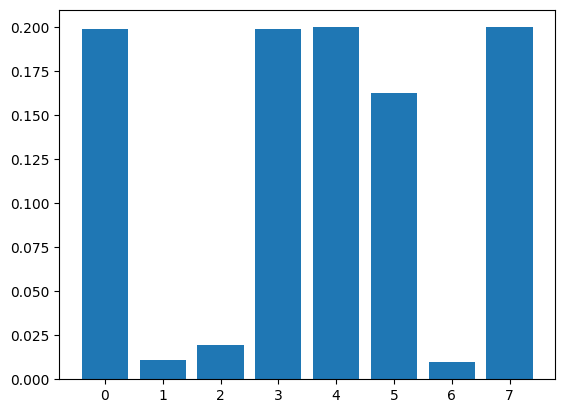

In [51]:
import matplotlib.pyplot as plt
plt.bar(range(2 ** len(wires)), probs)
plt.show()


In [60]:
def commutator_Hm_Hp(clauses,no_of_literals):
    coeffs = []
    terms = []
    for l in range(no_of_literals):
        coeffs += [1j]
        terms  += [qml.PauliY(l)]
        for clause in clauses:
            # Create two empty lists called n_coeffs and n_terms to store co-efficients and terms of each clause's cost function
            n_coeffs = []
            n_terms = []
            # Add \bar{W} terms to n_coeffs and n_terms for literals in first list 
            for j in clause[0]:
                if j!=l:
                    n_coeffs += [[0.5,0.5]]
                    n_terms  += [[qml.Identity(j),qml.PauliZ(j)]]
                elif j ==l:
                    sign = -1
            # Add W terms to n_coeffs and n_terms for literals in second list 
            for j in clause[1]:
                if j!=l:
                    n_coeffs += [[0.5,-0.5]]
                    n_terms  += [[qml.Identity(j),qml.PauliZ(j)]]
                elif j ==l:
                    sign = 1
            # Compute the product of all \bar{W} and W terms in lists n_coeffs and n_terms
            # Store them in two new lists called final_coeffs and final_terms
            final_coeffs   = [functools.reduce(lambda x, y: x * y, list(m), sign) for m in itertools.product(*n_coeffs)]
            final_terms    = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
            # Add the two new lists final_coeffs and final_terms to our coeffs and terms lists
            coeffs.extend(final_coeffs)
            terms.extend(final_terms)
    return qml.pauli.simplify(qml.Hamiltonian(coeffs,terms))

In [61]:
commutator_Hm_Hp(Clauses,3)

  ((-1+0j)) [Z2]
+ ((-0.5+0j)) [Z1]
+ ((-0.25+0j)) [I0]
+ (1j) [Y0]
+ (1j) [Y1]
+ (1j) [Y2]
+ ((0.25+0j)) [Z1 Z2]
+ ((0.25+0j)) [Z0 Z2]
+ ((0.25+0j)) [Z0 Z1]
